# SMARTINVEST - Système d'Analyse Prédictive des Cryptomonnaies (Version améliorée)

Ce notebook est une version améliorée du système SMARTINVEST avec les modifications suivantes :
- Utilisation de PCA pour le feature engineering
- Double niveau de clustering (cryptos et classes de prédiction)
- Optimisation des modèles KNN et arbres de décision
- Système de scoring unifié
- Détection d'anomalies prévisionnelle (2 semaines)

## 1. Import des bibliothèques et configuration

In [84]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 2. Chargement et préparation des données

In [85]:
# Liste des cryptomonnaies à analyser
crypto_list = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 
              'DOGE-USD', 'LTC-USD', 'LINK-USD']

# Période d'analyse
end_date = datetime.now()
start_date = end_date - timedelta(days=3654)  # 10 ans de données

print(f"Période : {start_date.date()} à {end_date.date()}")

# Fonction pour télécharger les données
def download_crypto_data(symbol, start_date, end_date):
    print(f"Téléchargement de {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date)
    
    if not data.empty:
        # Réinitialiser l'index pour avoir Date comme colonne
        data = data.reset_index()
        # Ajouter le ticker
        data['Ticker'] = symbol
        print(f"  {len(data)} lignes téléchargées pour {symbol}")
        data.columns = [col[0] for col in data.columns]
        return data
    else:
        print(f"  Aucune donnée pour {symbol}")
        return None

# APPROCHE 1 : Format long dès le départ (RECOMMANDÉE)
print("\n=== TÉLÉCHARGEMENT EN FORMAT LONG ===")

all_data = []
for crypto in crypto_list:
    df = download_crypto_data(crypto, start_date, end_date)
    if df is not None:
        # Réorganiser les colonnes pour avoir un format standard
        columns_order = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
        # Garder seulement les colonnes qui existent
        available_columns = [col for col in columns_order if col in df.columns]
        df = df[available_columns]
        
        all_data.append(df)

# Combiner tous les DataFrames en un seul
if all_data:  # Vérifier qu'on a des données
    
    # Afficher un résumé de chaque DataFrame avant combinaison
    for i, df in enumerate(all_data):
        df_combined = pd.concat(all_data, ignore_index=True)
    
    # Informations sur le DataFrame combiné
    print(f"Forme du DataFrame : {df_combined.shape}")
    print(f"Nombre total de lignes : {len(df_combined):,}")
    print(f"Cryptomonnaies incluses : {df_combined['Ticker'].unique()}")
    print(f"Période globale : {df_combined['Date'].min().date()} à {df_combined['Date'].max().date()}")
    
    # Aperçu des données
    print(f"\n=== APERÇU DES DONNÉES COMBINÉES ===")
    print(df_combined.head(10))

Période : 2015-09-12 à 2025-09-13

=== TÉLÉCHARGEMENT EN FORMAT LONG ===
Téléchargement de BTC-USD...


[*********************100%***********************]  1 of 1 completed


  3654 lignes téléchargées pour BTC-USD
Téléchargement de ETH-USD...


[*********************100%***********************]  1 of 1 completed


  2865 lignes téléchargées pour ETH-USD
Téléchargement de BNB-USD...


[*********************100%***********************]  1 of 1 completed


  2865 lignes téléchargées pour BNB-USD
Téléchargement de XRP-USD...


[*********************100%***********************]  1 of 1 completed


  2865 lignes téléchargées pour XRP-USD
Téléchargement de ADA-USD...


[*********************100%***********************]  1 of 1 completed


  2865 lignes téléchargées pour ADA-USD
Téléchargement de DOGE-USD...


[*********************100%***********************]  1 of 1 completed


  2865 lignes téléchargées pour DOGE-USD
Téléchargement de LTC-USD...


[*********************100%***********************]  1 of 1 completed


  3654 lignes téléchargées pour LTC-USD
Téléchargement de LINK-USD...


[*********************100%***********************]  1 of 1 completed

  2865 lignes téléchargées pour LINK-USD
Forme du DataFrame : (24498, 7)
Nombre total de lignes : 24,498
Cryptomonnaies incluses : ['BTC-USD' 'ETH-USD' 'BNB-USD' 'XRP-USD' 'ADA-USD' 'DOGE-USD' 'LTC-USD'
 'LINK-USD']
Période globale : 2015-09-12 à 2025-09-13

=== APERÇU DES DONNÉES COMBINÉES ===
        Date   Ticker        Open        High         Low       Close  \
0 2015-09-12  BTC-USD  239.854996  240.123993  234.753998  235.229004   
1 2015-09-13  BTC-USD  235.242004  235.934998  229.332001  230.511993   
2 2015-09-14  BTC-USD  230.608994  232.440002  227.960999  230.643997   
3 2015-09-15  BTC-USD  230.492004  259.182007  229.822006  230.304001   
4 2015-09-16  BTC-USD  230.250000  231.214996  227.401993  229.091003   
5 2015-09-17  BTC-USD  229.076004  230.285004  228.925995  229.809998   
6 2015-09-18  BTC-USD  233.520996  234.352997  232.184998  232.975006   
7 2015-09-19  BTC-USD  232.858002  233.205002  231.089005  231.492996   
8 2015-09-20  BTC-USD  231.399002  232.365005  

In [86]:
df_combined.sort_values(by=['Date'], inplace=True)
df_combined.reset_index(drop=True, inplace=True)
df_combined.head(10)

Date   Ticker        Open        High         Low       Close  \
0 2015-09-12  BTC-USD  239.854996  240.123993  234.753998  235.229004   
1 2015-09-12  LTC-USD    2.962570    2.970820    2.822920    2.825550   
2 2015-09-13  LTC-USD    2.824790    2.854670    2.774920    2.815940   
3 2015-09-13  BTC-USD  235.242004  235.934998  229.332001  230.511993   
4 2015-09-14  BTC-USD  230.608994  232.440002  227.960999  230.643997   
5 2015-09-14  LTC-USD    2.814920    2.862370    2.778060    2.844650   
6 2015-09-15  BTC-USD  230.492004  259.182007  229.822006  230.304001   
7 2015-09-15  LTC-USD    2.844200    2.934340    2.816790    2.823190   
8 2015-09-16  BTC-USD  230.250000  231.214996  227.401993  229.091003   
9 2015-09-16  LTC-USD    2.829940    2.845610    2.774110    2.802980   

     Volume  
0  17962600  
1   1517440  
2   1328080  
3  18478800  
4  20997800  
5   1135730  
6  19177800  
7    918109  
8  20144200  
9   1192860

## 2.1 Nettoyage et préparation des données

Nous allons :
1. Vérifier et gérer les doublons
2. Détecter et traiter les valeurs aberrantes
3. Gérer les valeurs manquantes
4. Vérifier la cohérence des données
5. Valider les types de données

In [87]:
# Affichage des périodes disponibles pour chaque crypto
print("Périodes disponibles par cryptomonnaie :")
periods = {}
for symbol in df_combined['Ticker'].unique():
    symbol_data = df_combined[df_combined['Ticker'] == symbol]
    periods[symbol] = {
        'début': symbol_data['Date'].min(),
        'fin': symbol_data['Date'].max(),
        'jours': (symbol_data['Date'].max() - symbol_data['Date'].min()).days
    }

for symbol, period in periods.items():
    print(f"{symbol}: du {period['début'].strftime('%Y-%m-%d')} au {period['fin'].strftime('%Y-%m-%d')} ({period['jours']} jours)")

# Trouver la période commune à toutes les cryptos
start_date = max([period['début'] for period in periods.values()])
end_date = min([period['fin'] for period in periods.values()])
print(f"\nPériode commune: du {start_date.strftime('%Y-%m-%d')} au {end_date.strftime('%Y-%m-%d')}")
print(f"Durée: {(end_date - start_date).days} jours")

# Filtrer les données pour ne garder que la période commune
df_combined = df_combined[
    (df_combined['Date'] >= start_date) & 
    (df_combined['Date'] <= end_date)
]

print("\nNombre d'observations après filtrage temporel:", len(df_combined))

# Vérification des doublons
print("\nNombre de doublons :", df_combined.duplicated().sum())
df_combined = df_combined.drop_duplicates()

# Vérification des types de données
print("\nTypes de données :")
print(df_combined.dtypes)

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df_combined.isnull().sum())

# Vérification de la cohérence des données
print("\nStatistiques descriptives :")
print(df_combined.describe())

# Détection des valeurs aberrantes (méthode IQR) - sans traitement
def detect_outliers(df, columns):
    outliers_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_info[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100
        }
    return outliers_info

numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
outliers = detect_outliers(df_combined, numerical_columns)

print("\nDétection des valeurs aberrantes :")
for col, info in outliers.items():
    print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}% des données)")

# Visualisation de la distribution des données avec outliers
fig = go.Figure()
for col in numerical_columns:
    fig.add_trace(go.Box(y=df_combined[col], name=col))
fig.update_layout(title='Distribution des variables avec outliers',
                 yaxis_type="log",  # Échelle logarithmique pour mieux voir la distribution
                 showlegend=True)
fig.show()

# Vérification de la cohérence des prix OHLC
price_errors = df_combined[
    (df_combined['High'] < df_combined['Low']) |
    (df_combined['Open'] > df_combined['High']) |
    (df_combined['Open'] < df_combined['Low']) |
    (df_combined['Close'] > df_combined['High']) |
    (df_combined['Close'] < df_combined['Low'])
]

print("\nNombre d'incohérences dans les prix OHLC :", len(price_errors))

# Si des incohérences sont trouvées, les corriger
if len(price_errors) > 0:
    print("Correction des incohérences OHLC...")
    for idx in price_errors.index:
        row_data = df_combined.loc[idx, ['Open', 'High', 'Low', 'Close']]
        df_combined.loc[idx, 'High'] = row_data.max()
        df_combined.loc[idx, 'Low'] = row_data.min()

# Vérification finale des données
print("\nRésumé final des données :")
print(df_combined.info())

Périodes disponibles par cryptomonnaie :
BTC-USD: du 2015-09-12 au 2025-09-13 (3654 jours)
LTC-USD: du 2015-09-12 au 2025-09-13 (3654 jours)
ADA-USD: du 2017-11-09 au 2025-09-13 (2865 jours)
ETH-USD: du 2017-11-09 au 2025-09-13 (2865 jours)
LINK-USD: du 2017-11-09 au 2025-09-13 (2865 jours)
XRP-USD: du 2017-11-09 au 2025-09-13 (2865 jours)
DOGE-USD: du 2017-11-09 au 2025-09-13 (2865 jours)
BNB-USD: du 2017-11-09 au 2025-09-13 (2865 jours)

Période commune: du 2017-11-09 au 2025-09-13
Durée: 2865 jours

Nombre d'observations après filtrage temporel: 22920

Nombre de doublons : 0

Types de données :
Date      datetime64[ns]
Ticker            object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

Valeurs manquantes par colonne :
Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Statistiques descriptives :
                                Date          


Nombre d'incohérences dans les prix OHLC : 0

Résumé final des données :
<class 'pandas.core.frame.DataFrame'>
Index: 22920 entries, 1578 to 24497
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    22920 non-null  datetime64[ns]
 1   Ticker  22920 non-null  object        
 2   Open    22920 non-null  float64       
 3   High    22920 non-null  float64       
 4   Low     22920 non-null  float64       
 5   Close   22920 non-null  float64       
 6   Volume  22920 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


## 2.2 Analyse exploratoire des données (EDA)

Analysons visuellement nos données pour mieux comprendre les tendances et les relations entre les variables.

In [88]:
df_plot = df_combined.copy()
print("Structure finale du DataFrame :")
print(df_plot.info())
print(f"\nNombre de lignes : {len(df_plot)}")
print(f"Tickers uniques : {df_plot['Ticker'].unique()}")
print("\nPremières lignes :")
print(df_plot.head(10))
# ============================================================
# 1. Évolution des prix par crypto
# ============================================================
fig = px.line(df_plot, 
              x='Date', 
              y='Close', 
              color='Ticker',
              title='Évolution des prix des cryptomonnaies')
fig.show()

# ============================================================
# 2. Distribution des rendements journaliers
# ============================================================
df_plot['Returns'] = df_plot.groupby('Ticker')['Close'].pct_change()

fig = px.box(df_plot, 
             x='Ticker', 
             y='Returns',
             title='Distribution des rendements journaliers par cryptomonnaie')
fig.show()

# ============================================================
# 3. Matrice de corrélation des prix de clôture
# ============================================================
pivot_close = df_plot.pivot_table(index='Date', columns='Ticker', values='Close')
correlation_matrix = pivot_close.corr()

fig = px.imshow(correlation_matrix,
                labels=dict(color="Corrélation"),
                title='Matrice de corrélation des prix')
fig.show()

# ============================================================
# 4. Calcul RSI (14 périodes) et Volatilité (30 jours)
# ============================================================
window = 14

delta = df_plot.groupby('Ticker')['Close'].diff()      # utiliser Ticker
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.groupby(df_plot['Ticker']).transform(lambda x: x.rolling(window).mean())
avg_loss = loss.groupby(df_plot['Ticker']).transform(lambda x: x.rolling(window).mean())

rs = avg_gain / avg_loss
df_plot['RSI'] = 100 - (100 / (1 + rs))

# Volatilité (écart-type glissant sur 30 jours des rendements)
df_plot['Volatility'] = (
    df_plot.groupby('Ticker')['Returns']
    .rolling(30)
    .std()
    .reset_index(level=0, drop=True)
)

df_plot['Volatility'] = df_plot.groupby('Ticker')['Volatility'].transform(
    lambda x: x.fillna(method='bfill')
)

df_plot['RSI'] = df_plot.groupby('Ticker')['RSI'].transform(
    lambda x: x.fillna(method='bfill')
)

# ============================================================
# 5. Analyse de la volatilité
# ============================================================
volatility_by_crypto = df_plot.groupby('Ticker')['Volatility'].mean().sort_values(ascending=False)

fig = px.bar(volatility_by_crypto,
             title='Volatilité moyenne par cryptomonnaie')
fig.show()

# ============================================================
# 6. Analyse du volume
# ============================================================
fig = px.bar(df_plot, 
             x='Ticker', 
             y='Volume',
             title="Distribution du volume d'échanges par cryptomonnaie",
             color='Ticker')
fig.show()

# ============================================================
# 7. Analyse du RSI
# ============================================================
fig = px.line(df_plot, 
              x='Date', 
              y='RSI', 
              color='Ticker',
              title='Évolution du RSI par cryptomonnaie')
fig.add_hline(y=70, line_dash="dash", line_color="red")
fig.add_hline(y=30, line_dash="dash", line_color="green")
fig.show()

# ============================================================
# 8. Statistiques descriptives par crypto
# ============================================================
summary_stats = df_plot.groupby('Ticker').agg({
    'Close': ['mean', 'std', 'min', 'max'],
    'Volume': ['mean', 'std'],
    'Returns': ['mean', 'std'],
    'Volatility': 'mean',
    'RSI': 'mean'
}).round(4)

print("\nStatistiques descriptives par cryptomonnaie :")
print(summary_stats)


Structure finale du DataFrame :
<class 'pandas.core.frame.DataFrame'>
Index: 22920 entries, 1578 to 24497
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    22920 non-null  datetime64[ns]
 1   Ticker  22920 non-null  object        
 2   Open    22920 non-null  float64       
 3   High    22920 non-null  float64       
 4   Low     22920 non-null  float64       
 5   Close   22920 non-null  float64       
 6   Volume  22920 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None

Nombre de lignes : 22920
Tickers uniques : ['ADA-USD' 'ETH-USD' 'LINK-USD' 'XRP-USD' 'DOGE-USD' 'LTC-USD' 'BNB-USD'
 'BTC-USD']

Premières lignes :
           Date    Ticker         Open         High          Low        Close  \
1578 2017-11-09   ADA-USD     0.025160     0.035060     0.025006     0.032053   
1579 2017-11-09   ETH-USD   308.644989   329.451996   307.056000   32


Statistiques descriptives par cryptomonnaie :
               Close                                            Volume  \
                mean         std        min          max          mean   
Ticker                                                                   
ADA-USD       0.5015      0.5226     0.0240       2.9682  9.950460e+08   
BNB-USD     260.3018    242.6773     1.5104     925.9138  1.122781e+09   
BTC-USD   34321.9728  29905.7869  3236.7617  123344.0625  2.866894e+10   
DOGE-USD      0.0900      0.1032     0.0010       0.6848  1.226632e+09   
ETH-USD    1611.5991   1259.1558    84.3083    4831.3486  1.419542e+10   
LINK-USD     10.4787      9.2007     0.1453      52.1987  6.610216e+08   
LTC-USD      95.9019     53.0344    23.4643     386.4508  1.743955e+09   
XRP-USD       0.7298      0.6808     0.1396       3.5558  2.794890e+09   

                       Returns         Volatility      RSI  
                   std    mean     std       mean     mean  
Ticker          

## 2.3 Analyse par régression linéaire

Nous allons effectuer une analyse de régression linéaire pour comprendre les relations entre les variables et leur pouvoir prédictif.

In [89]:
def add_indicators(df, window=14):
    """
    Ajoute RSI et Volatilité à un DataFrame mono-crypto (Close, Volume, etc.)
    """
    df = df.copy()

    # Calcul du delta
    delta = df['Close'].diff()

    # Gains et pertes
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Moyenne mobile des gains et pertes
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Rendements journaliers
    df['Returns'] = df['Close'].pct_change()

    # Volatilité = écart-type glissant sur 30 jours des rendements
    df['Volatility'] = df['Returns'].rolling(30).std()

    return df


In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

linear_data=pd.DataFrame()
def perform_linear_regression(df, crypto):
    global linear_data
    # Filtrer les données pour la crypto spécifique
    crypto_data = df[df['Ticker'] == crypto].copy()
    crypto_data = add_indicators(crypto_data)
    
    # Créer des features pour la régression
    crypto_data['MA5'] = crypto_data['Close'].rolling(window=5).mean()
    crypto_data['MA20'] = crypto_data['Close'].rolling(window=20).mean()
    crypto_data['Price_Lag1'] = crypto_data['Close'].shift(1)
    crypto_data['Volume_Lag1'] = crypto_data['Volume'].shift(1)
    crypto_data['Future_price'] = crypto_data['Close'].shift(-1)  # Prix futur pour prédiction
    
    # Supprimer les lignes avec des valeurs manquantes
    crypto_data = crypto_data.dropna()
    
    # Préparer les features et la target
    X = crypto_data[['MA5', 'MA20', 'Price_Lag1', 'Volume_Lag1', 'RSI', 'Volatility', 'Close']]
    y = crypto_data['Future_price']
    
    #ajout des lignes de crypto_data à dans linear_data
    linear_data = pd.concat([linear_data, crypto_data], ignore_index=True)

    # Diviser les données (80-20)
    split_idx = int(len(crypto_data) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Entraîner le modèle
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Faire des prédictions
    y_pred = model.predict(X_test)
    
    # Calculer les métriques
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Créer un DataFrame avec les coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    
    return {
        'r2': r2,
        'rmse': rmse,
        'coefficients': coef_df,
        'y_test': y_test,
        'y_pred': y_pred,
        'dates': crypto_data.index[split_idx:]
    }

# Effectuer la régression pour chaque crypto
regression_results = {}
for crypto in df_combined['Ticker'].unique():
    regression_results[crypto] = perform_linear_regression(df_combined, crypto)

# Afficher les résultats
for crypto, results in regression_results.items():
    print(f"\nRésultats pour {crypto}:")
    print(f"R² Score: {results['r2']:.4f}")
    print(f"RMSE: {results['rmse']:.4f}")
    print("\nCoefficients:")
    print(results['coefficients'])
    
    # Visualiser les prédictions vs réalité
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=results['dates'], y=results['y_test'],
                            mode='lines', name='Réel',
                            line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=results['dates'], y=results['y_pred'],
                            mode='lines', name='Prédiction',
                            line=dict(color='red')))
    fig.update_layout(title=f'Prédictions vs Réalité pour {crypto}',
                     xaxis_title='Date',
                     yaxis_title='Prix')
    fig.show()


Résultats pour ADA-USD:
R² Score: 0.9701
RMSE: 0.0386

Coefficients:
       Feature   Coefficient
0          MA5  3.424758e-02
1         MA20 -4.914018e-03
2   Price_Lag1  5.802114e-02
3  Volume_Lag1 -3.560052e-13
4          RSI  1.213990e-04
5   Volatility  3.695906e-02
6        Close  9.100634e-01



Résultats pour ETH-USD:
R² Score: 0.9743
RMSE: 112.1180

Coefficients:
       Feature   Coefficient
0          MA5 -6.910204e-02
1         MA20  2.012522e-02
2   Price_Lag1  1.087671e-01
3  Volume_Lag1  5.157780e-11
4          RSI  1.931764e-01
5   Volatility -2.515444e+01
6        Close  9.381461e-01



Résultats pour LINK-USD:
R² Score: 0.9594
RMSE: 0.8784

Coefficients:
       Feature   Coefficient
0          MA5 -1.492420e-01
1         MA20  4.969681e-02
2   Price_Lag1  2.382215e-01
3  Volume_Lag1 -7.788103e-12
4          RSI  2.424581e-03
5   Volatility -5.799641e-01
6        Close  8.585119e-01



Résultats pour XRP-USD:
R² Score: 0.9905
RMSE: 0.0983

Coefficients:
       Feature   Coefficient
0          MA5 -7.334761e-02
1         MA20 -8.166796e-03
2   Price_Lag1  5.286301e-02
3  Volume_Lag1 -4.509414e-13
4          RSI  6.606735e-05
5   Volatility  1.431368e-01
6        Close  1.005955e+00



Résultats pour DOGE-USD:
R² Score: 0.9791
RMSE: 0.0123

Coefficients:
       Feature   Coefficient
0          MA5 -2.598142e-01
1         MA20  9.712660e-02
2   Price_Lag1  2.391720e-01
3  Volume_Lag1  4.306000e-13
4          RSI  2.861712e-05
5   Volatility  1.299912e-03
6        Close  9.102810e-01



Résultats pour LTC-USD:
R² Score: 0.9544
RMSE: 4.0848

Coefficients:
       Feature   Coefficient
0          MA5 -5.611255e-02
1         MA20  9.064726e-03
2   Price_Lag1  5.832537e-02
3  Volume_Lag1  1.776477e-11
4          RSI  1.153749e-02
5   Volatility  1.031929e+01
6        Close  9.781007e-01



Résultats pour BNB-USD:
R² Score: 0.9641
RMSE: 17.1833

Coefficients:
       Feature   Coefficient
0          MA5 -1.377110e-01
1         MA20  1.330700e-02
2   Price_Lag1  2.302555e-01
3  Volume_Lag1  1.766539e-10
4          RSI  2.648048e-02
5   Volatility -1.568649e+00
6        Close  8.911767e-01



Résultats pour BTC-USD:
R² Score: 0.9896
RMSE: 2042.4777

Coefficients:
       Feature   Coefficient
0          MA5 -3.976257e-02
1         MA20  6.955005e-03
2   Price_Lag1  6.339682e-02
3  Volume_Lag1 -7.287686e-10
4          RSI  2.151283e+00
5   Volatility  6.295252e+02
6        Close  9.685640e-01


In [91]:
linear_data.head()

Date   Ticker      Open      High       Low     Close    Volume  \
0 2017-12-09  ADA-USD  0.114745  0.138660  0.113561  0.119609  63308600   
1 2017-12-10  ADA-USD  0.119794  0.119794  0.100133  0.110281  46376600   
2 2017-12-11  ADA-USD  0.108927  0.121383  0.108638  0.121383  39513900   
3 2017-12-12  ADA-USD  0.121177  0.138008  0.114222  0.133891  60056800   
4 2017-12-13  ADA-USD  0.133739  0.141854  0.122368  0.134281  61575000   

         RSI   Returns  Volatility       MA5      MA20  Price_Lag1  \
0  71.124433  0.035890    0.275864  0.117180  0.085314    0.115465   
1  67.238896 -0.077987    0.274100  0.113739  0.089349    0.119609   
2  66.749163  0.100670    0.273922  0.114448  0.094002    0.110281   
3  54.572960  0.103046    0.271346  0.120126  0.099269    0.121383   
4  67.818787  0.002913    0.271722  0.123889  0.104611    0.133891   

   Volume_Lag1  Future_price  
0   70092400.0      0.110281  
1   63308600.0      0.121383  
2   46376600.0      0.133891  
3   39513900.0      0.134281  
4   60056800.0      0.240753

## 3. Calcul des indicateurs techniques essentiels (Volatilité et RSI)

In [92]:
def calculate_rsi_safe(data, periods=14):
    """RSI sécurisé avec gestion division par zéro"""
    close_delta = data['Close'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.rolling(window=periods).mean()
    ma_down = down.rolling(window=periods).mean()
    
    rsi = np.where(ma_down == 0, 100, 100 - (100 / (1 + ma_up / ma_down)))
    return pd.Series(rsi, index=data.index)

# Calcul des indicateurs
df_combined['Volatility'] = df_combined.groupby('Ticker')['Close'].transform(
    lambda x: x.rolling(window=14).std()
)

df_combined['RSI'] = df_combined.groupby('Ticker').apply(
    lambda group: calculate_rsi_safe(group, periods=14)
).reset_index(level=0, drop=True)

# Forward fill des NaN par groupe (ticker)
df_combined['Volatility'] = df_combined.groupby('Ticker')['Volatility'].transform(
    lambda x: x.fillna(method='bfill')
)

df_combined['RSI'] = df_combined.groupby('Ticker')['RSI'].transform(
    lambda x: x.fillna(method='bfill')
)

# Vérification finale
print("NaN restants :")
print(f"Volatility: {df_combined['Volatility'].isnull().sum()}")
print(f"RSI: {df_combined['RSI'].isnull().sum()}")

print("\nAperçu des premières lignes BTC :")
btc_sample = df_combined[df_combined['Ticker'] == 'BTC-USD'][
    ['Date', 'Close', 'Volatility', 'RSI']
].head(20)
print(btc_sample)

NaN restants :
Volatility: 0
RSI: 0

Aperçu des premières lignes BTC :
           Date         Close  Volatility        RSI
1585 2017-11-09   7143.580078  773.338224  60.419049
1592 2017-11-10   6618.140137  773.338224  60.419049
1597 2017-11-11   6357.600098  773.338224  60.419049
1608 2017-11-12   5950.069824  773.338224  60.419049
1610 2017-11-13   6559.490234  773.338224  60.419049
1622 2017-11-14   6635.750000  773.338224  60.419049
1627 2017-11-15   7315.540039  773.338224  60.419049
1641 2017-11-16   7871.689941  773.338224  60.419049
1646 2017-11-17   7708.990234  773.338224  60.419049
1657 2017-11-18   7790.149902  773.338224  60.419049
1665 2017-11-19   8036.490234  773.338224  60.419049
1673 2017-11-20   8200.639648  773.338224  60.419049
1676 2017-11-21   8071.259766  773.338224  60.419049
1683 2017-11-22   8253.549805  773.338224  60.419049
1695 2017-11-23   8038.770020  794.148291  60.419049
1705 2017-11-24   8253.690430  792.754175  70.519224
1712 2017-11-25   8790.91992

In [93]:
df_combined.reset_index(drop=True, inplace=True)
df_combined.head()

Date    Ticker        Open        High         Low       Close  \
0 2017-11-09   ADA-USD    0.025160    0.035060    0.025006    0.032053   
1 2017-11-09   ETH-USD  308.644989  329.451996  307.056000  320.884003   
2 2017-11-09  LINK-USD    0.216713    0.248233    0.195411    0.223969   
3 2017-11-09   XRP-USD    0.217911    0.221791    0.214866    0.217488   
4 2017-11-09  DOGE-USD    0.001207    0.001415    0.001181    0.001415   

      Volume  Volatility        RSI  
0   18716200    0.001950  38.761274  
1  893249984   23.614199  75.929635  
2    3347920    0.017502  29.245760  
3  147916992    0.013571  64.632230  
4    6259550    0.000182  65.616800

## 4. Premier niveau de clustering (entre cryptomonnaies)

In [94]:
# Préparation des données pour le clustering des cryptos
def prepare_crypto_features(df):
    features = []
    for Ticker in df['Ticker'].unique():
        crypto_data = df[df['Ticker'] == Ticker]
        feature_dict = {
            'Ticker': Ticker,
            'Mean_Return': crypto_data['Close'].pct_change().mean(),
            'Volatility': crypto_data['Volatility'].mean(),
            'Volume': crypto_data['Volume'].mean(),
            'RSI_Mean': crypto_data['RSI'].mean()
        }
        features.append(feature_dict)
    return pd.DataFrame(features)

# Création des features pour le clustering
crypto_features = prepare_crypto_features(df_plot)

# Normalisation des features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(crypto_features.drop('Ticker', axis=1))

# Recherche du nombre optimal de clusters
max_clusters = 5
silhouette_scores = []
ch_scores = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    silhouette_scores.append(silhouette_score(features_scaled, labels))
    ch_scores.append(calinski_harabasz_score(features_scaled, labels))

# Sélection du nombre optimal de clusters
optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Application du clustering final
kmeans_final = KMeans(n_clusters=optimal_n_clusters, random_state=42)
crypto_features['Cluster'] = kmeans_final.fit_predict(features_scaled)


In [95]:
from sklearn.manifold import TSNE

# Supposons que crypto_features contient vos données avec la colonne 'Cluster'
# Adaptation selon vos colonnes réelles

def visualize_clusters_with_reduction(crypto_features):
    """
    Visualise les clusters avec différentes techniques de réduction de dimensionnalité
    """
    
    # Sélection des features numériques (exclure Ticker et Cluster)
    numeric_cols = crypto_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in ['Cluster']]
    
    print(f"Features utilisées pour la réduction : {feature_cols}")
    
    # Données pour la réduction de dimensionnalité
    X = crypto_features[feature_cols].values
    
    # =============== PCA (2D) ===============
    pca_2d = PCA(n_components=2, random_state=42)
    pca_coords = pca_2d.fit_transform(X)
    
    crypto_pca = crypto_features.copy()
    crypto_pca['PCA1'] = pca_coords[:, 0]
    crypto_pca['PCA2'] = pca_coords[:, 1]
    
    # =============== t-SNE (2D) ===============
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=min(5, len(X)-1))
    tsne_coords = tsne_2d.fit_transform(X)
    
    crypto_tsne = crypto_features.copy()
    crypto_tsne['TSNE1'] = tsne_coords[:, 0]
    crypto_tsne['TSNE2'] = tsne_coords[:, 1]
    
    # =============== PCA 3D (optionnel) ===============
    pca_3d = PCA(n_components=3, random_state=42)
    pca_3d_coords = pca_3d.fit_transform(X)
    
    crypto_pca_3d = crypto_features.copy()
    crypto_pca_3d['PCA1'] = pca_3d_coords[:, 0]
    crypto_pca_3d['PCA2'] = pca_3d_coords[:, 1]
    crypto_pca_3d['PCA3'] = pca_3d_coords[:, 2]
    
    # =============== CRÉATION DES GRAPHIQUES ===============
    
    # Couleurs personnalisées pour les clusters
    colors = px.colors.qualitative.Set3
    
    # Subplot avec 4 graphiques
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            'Clustering Original (Volatilité vs Rendement)',
            'PCA - Réduction 2D',
            't-SNE - Réduction 2D', 
            'PCA 3D'
        ],
        specs=[[{"type": "scatter"}, {"type": "scatter"}],
               [{"type": "scatter"}, {"type": "scatter3d"}]]
    )
    
    # Graphique 1: Original (si vous avez Volatility et Mean_Return)
    if 'Volatility' in crypto_features.columns and 'Mean_Return' in crypto_features.columns:
        for cluster in sorted(crypto_features['Cluster'].unique()):
            cluster_data = crypto_features[crypto_features['Cluster'] == cluster]
            fig.add_trace(
                go.Scatter(
                    x=cluster_data['Volatility'],
                    y=cluster_data['Mean_Return'],
                    mode='markers+text',
                    text=cluster_data['Ticker'],
                    textposition="top center",
                    name=f'Cluster {cluster}',
                    marker=dict(size=12, color=colors[cluster % len(colors)]),
                    showlegend=True
                ),
                row=1, col=1
            )
    
    # Graphique 2: PCA 2D
    for cluster in sorted(crypto_pca['Cluster'].unique()):
        cluster_data = crypto_pca[crypto_pca['Cluster'] == cluster]
        fig.add_trace(
            go.Scatter(
                x=cluster_data['PCA1'],
                y=cluster_data['PCA2'],
                mode='markers+text',
                text=cluster_data['Ticker'],
                textposition="top center",
                name=f'Cluster {cluster}',
                marker=dict(size=12, color=colors[cluster % len(colors)]),
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Graphique 3: t-SNE 2D
    for cluster in sorted(crypto_tsne['Cluster'].unique()):
        cluster_data = crypto_tsne[crypto_tsne['Cluster'] == cluster]
        fig.add_trace(
            go.Scatter(
                x=cluster_data['TSNE1'],
                y=cluster_data['TSNE2'],
                mode='markers+text',
                text=cluster_data['Ticker'],
                textposition="top center",
                name=f'Cluster {cluster}',
                marker=dict(size=12, color=colors[cluster % len(colors)]),
                showlegend=False
            ),
            row=2, col=1
        )
    
    # Graphique 4: PCA 3D
    for cluster in sorted(crypto_pca_3d['Cluster'].unique()):
        cluster_data = crypto_pca_3d[crypto_pca_3d['Cluster'] == cluster]
        fig.add_trace(
            go.Scatter3d(
                x=cluster_data['PCA1'],
                y=cluster_data['PCA2'],
                z=cluster_data['PCA3'],
                mode='markers+text',
                text=cluster_data['Ticker'],
                name=f'Cluster {cluster}',
                marker=dict(size=8, color=colors[cluster % len(colors)]),
                showlegend=False
            ),
            row=2, col=2
        )
    
    # Mise en forme
    fig.update_layout(
        height=800,
        title_text="Analyse de Clustering - Cryptomonnaies avec Réduction de Dimensionnalité",
        title_x=0.5
    )
    
    # Axes labels
    fig.update_xaxes(title_text="Volatilité", row=1, col=1)
    fig.update_yaxes(title_text="Rendement Moyen", row=1, col=1)
    
    fig.update_xaxes(title_text=f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)", row=1, col=2)
    fig.update_yaxes(title_text=f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)", row=1, col=2)
    
    fig.update_xaxes(title_text="t-SNE 1", row=2, col=1)
    fig.update_yaxes(title_text="t-SNE 2", row=2, col=1)
    
    fig.show()
    
    # =============== INFORMATIONS ADDITIONNELLES ===============
    print("\\n=== INFORMATIONS PCA ===")
    print(f"Variance expliquée PC1: {pca_2d.explained_variance_ratio_[0]:.1%}")
    print(f"Variance expliquée PC2: {pca_2d.explained_variance_ratio_[1]:.1%}")
    print(f"Variance totale expliquée (2D): {pca_2d.explained_variance_ratio_.sum():.1%}")
    
    print(f"\\nVariance expliquée PCA 3D: {pca_3d.explained_variance_ratio_.sum():.1%}")
    
    print("\\n=== DISTRIBUTION DES CLUSTERS ===")
    print(crypto_features['Cluster'].value_counts().sort_index())
    
    return crypto_pca, crypto_tsne, pca_2d, tsne_2d

# Utilisation
crypto_pca, crypto_tsne, pca_model, tsne_model = visualize_clusters_with_reduction(crypto_features)

Features utilisées pour la réduction : ['Mean_Return', 'Volatility', 'Volume', 'RSI_Mean']


\n=== INFORMATIONS PCA ===
Variance expliquée PC1: 100.0%
Variance expliquée PC2: 0.0%
Variance totale expliquée (2D): 100.0%
\nVariance expliquée PCA 3D: 100.0%
\n=== DISTRIBUTION DES CLUSTERS ===
Cluster
0    6
1    2
Name: count, dtype: int64


## 5. Feature Engineering avec PCA

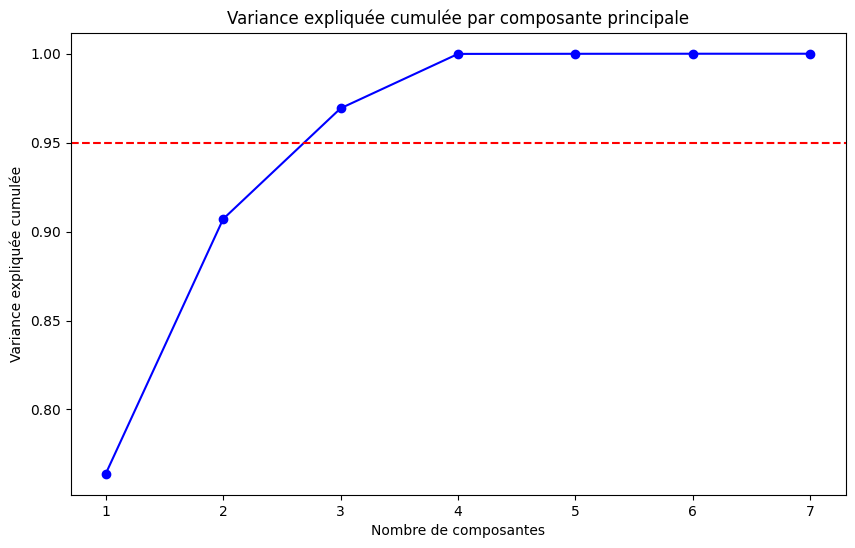

In [96]:
# Préparation des features pour PCA
features_for_pca = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'RSI']

# Normalisation des données
scaler_pca = StandardScaler()
features_scaled_pca = scaler_pca.fit_transform(df_combined[features_for_pca])

# Application de la PCA
pca = PCA()
features_pca = pca.fit_transform(features_scaled_pca)

# Calcul de la variance expliquée cumulée
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par composante principale')
plt.show()

In [97]:

n_components=4  # Choix basé sur le graphique de variance expliquée

# Application de la PCA finale
pca_final = PCA(n_components=n_components)
features_pca_final = pca_final.fit_transform(features_scaled_pca)

# Création du DataFrame avec les composantes principales
pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(features_pca_final, columns=pca_columns)

# Ajout des informations importantes au DataFrame PCA
df_pca['Ticker'] = df_combined['Ticker']
df_pca['Date'] = df_combined['Date']
df_pca['Close'] = df_combined['Close']

In [98]:
df_plot.isnull().sum()

Date          0
Ticker        0
Open          0
High          0
Low           0
Close         0
Volume        0
Returns       8
RSI           0
Volatility    0
dtype: int64

In [99]:
#remplacer les NaN de returns par la moyenne de la colonne
df_plot['Returns'].fillna(df_plot['Returns'].mean(), inplace=True)


## 6. Deuxième niveau de clustering (classes de prédiction)

=== CLUSTERING DE 22,920 JOURS DE TRADING ===
Clusters 2: Silhouette = 0.324
Clusters 3: Silhouette = 0.212
Clusters 4: Silhouette = 0.218
Clusters 5: Silhouette = 0.223
Clusters 6: Silhouette = 0.215
Clusters 7: Silhouette = 0.216

>>> CLUSTERS OPTIMAUX: 2
>>> DISTRIBUTION:
Risk_Cluster
0    19544
1     3376
Name: count, dtype: int64

=== PROFILS DES CLUSTERS ===
                  RSI                           Volatility                  \
                 mean      std     min      max       mean     std     min   
Risk_Cluster                                                                 
0             49.4430  17.2834  4.6995  98.3317     0.0508  0.0391  0.0081   
1             58.9848  16.3091  9.6585  99.2195     0.0360  0.0143  0.0089   

                     Returns                                Volume  \
                 max    mean     std     min     max          mean   
Risk_Cluster                                                         
0             0.6754  0.0029  0.

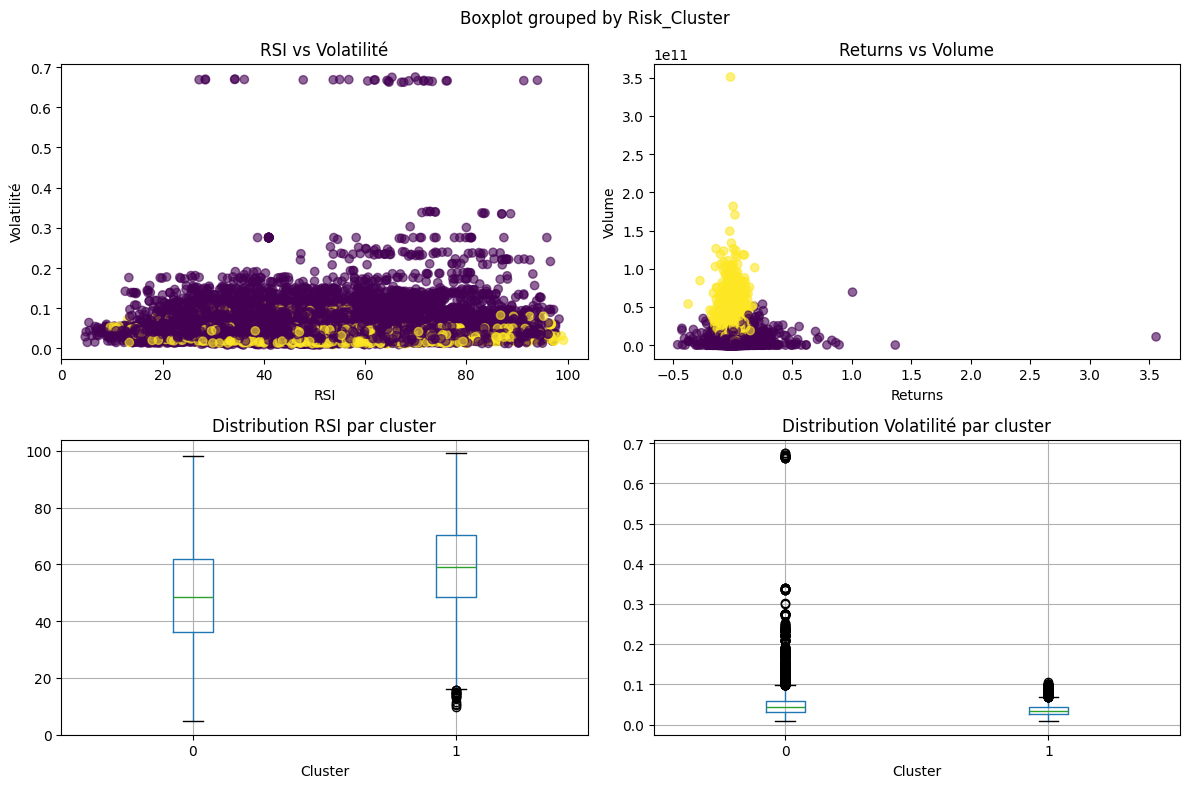


=== SYNTHÈSE DES DÉCOUVERTES ===

Cluster 0 - RISQUE ÉLEVÉ (19,544 jours):
  RSI moyen: 49.4
  Volatilité moyenne: 0.0508
  Return moyen: 0.0029

Cluster 1 - FAIBLE RISQUE (3,376 jours):
  RSI moyen: 59.0
  Volatilité moyenne: 0.0360
  Return moyen: 0.0023


In [100]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# =============== PHASE 1: CLUSTERING EXPLORATOIRE ===============

# Sélection des features pour clustering
features_clustering = ['RSI', 'Volatility', 'Returns', 'Volume']
X = df_plot[features_clustering].dropna()

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"=== CLUSTERING DE {len(X):,} JOURS DE TRADING ===")

# Recherche nombre optimal de clusters
silhouette_scores = []
for n in range(2, 8):
    clustering = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = clustering.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"Clusters {n}: Silhouette = {score:.3f}")

# Clustering optimal
optimal_n = silhouette_scores.index(max(silhouette_scores)) + 2
clustering_final = AgglomerativeClustering(n_clusters=optimal_n, linkage='ward')
df_plot['Risk_Cluster'] = clustering_final.fit_predict(X_scaled)

print(f"\n>>> CLUSTERS OPTIMAUX: {optimal_n}")
print(f">>> DISTRIBUTION:")
print(df_plot['Risk_Cluster'].value_counts().sort_index())

# =============== ANALYSE DES CARACTÉRISTIQUES ===============

print(f"\n=== PROFILS DES CLUSTERS ===")

# Statistiques par cluster
cluster_stats = df_plot.groupby('Risk_Cluster')[features_clustering].agg(['mean', 'std', 'min', 'max'])
print(cluster_stats.round(4))

# Percentiles par cluster
print(f"\n=== PERCENTILES PAR CLUSTER ===")
for cluster in sorted(df_plot['Risk_Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    cluster_data = df_plot[df_plot['Risk_Cluster'] == cluster][features_clustering]
    percentiles = cluster_data.quantile([0.25, 0.5, 0.75])
    print(percentiles.round(4))

# Seuils caractéristiques
print(f"\n=== SEUILS CARACTÉRISTIQUES ===")
for cluster in sorted(df_plot['Risk_Cluster'].unique()):
    cluster_data = df_plot[df_plot['Risk_Cluster'] == cluster]
    
    rsi_range = f"{cluster_data['RSI'].min():.1f} - {cluster_data['RSI'].max():.1f}"
    vol_range = f"{cluster_data['Volatility'].min():.3f} - {cluster_data['Volatility'].max():.3f}"
    ret_range = f"{cluster_data['Returns'].min():.3f} - {cluster_data['Returns'].max():.3f}"
    
    print(f"Cluster {cluster}:")
    print(f"  RSI: {rsi_range} (moy: {cluster_data['RSI'].mean():.1f})")
    print(f"  Volatilité: {vol_range} (moy: {cluster_data['Volatility'].mean():.3f})")
    print(f"  Returns: {ret_range} (moy: {cluster_data['Returns'].mean():.3f})")

# =============== VISUALISATION ===============

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# RSI vs Volatility
axes[0,0].scatter(df_plot['RSI'], df_plot['Volatility'], c=df_plot['Risk_Cluster'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('RSI')
axes[0,0].set_ylabel('Volatilité')
axes[0,0].set_title('RSI vs Volatilité')

# Returns vs Volume  
axes[0,1].scatter(df_plot['Returns'], df_plot['Volume'], c=df_plot['Risk_Cluster'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Returns')
axes[0,1].set_ylabel('Volume')
axes[0,1].set_title('Returns vs Volume')

# Distribution RSI par cluster
df_plot.boxplot(column='RSI', by='Risk_Cluster', ax=axes[1,0])
axes[1,0].set_title('Distribution RSI par cluster')
axes[1,0].set_xlabel('Cluster')

# Distribution Volatilité par cluster
df_plot.boxplot(column='Volatility', by='Risk_Cluster', ax=axes[1,1])
axes[1,1].set_title('Distribution Volatilité par cluster')
axes[1,1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

# =============== SYNTHÈSE ===============

print(f"\n=== SYNTHÈSE DES DÉCOUVERTES ===")
cluster_means = df_plot.groupby('Risk_Cluster')[features_clustering].mean()

for cluster in sorted(df_plot['Risk_Cluster'].unique()):
    profile = cluster_means.loc[cluster]
    count = len(df_plot[df_plot['Risk_Cluster'] == cluster])
    
    # Caractérisation automatique
    if profile['Volatility'] < cluster_means['Volatility'].median():
        risk_type = "FAIBLE RISQUE"
    else:
        risk_type = "RISQUE ÉLEVÉ"
    
    print(f"\nCluster {cluster} - {risk_type} ({count:,} jours):")
    print(f"  RSI moyen: {profile['RSI']:.1f}")
    print(f"  Volatilité moyenne: {profile['Volatility']:.4f}")
    print(f"  Return moyen: {profile['Returns']:.4f}")

### Volume de trading :

Nombre d'unités de crypto échangées ce jour-là
Indicateur de liquidité : Plus le volume est élevé, plus il y a d'intérêt/activité
Signe d'événements : Annonces, news, mouvements de prix attirent les traders

**Observations clés :**
Cluster 0 (18,954 jours) - "Jours normaux":

Volume faible : ~1.8 milliards (médiane 754M)
Volatilité élevée : 5.13% en moyenne
82% des jours → Activité quotidienne normale

Cluster 1 (3,958 jours) - "Jours d'événements":

Volume énorme : ~28 milliards (médiane 23.6B)
Volatilité plus faible : 3.59% en moyenne
18% des jours → Événements/news majeurs

**Interprétation business :**
Cluster 1 = Jours de forte activité institutionnelle/événementielle

Beaucoup de volume mais volatilité contrôlée
Possibles : listings, partenariats, adoption institutionnelle

Cluster 0 = Trading retail quotidien

Volume normal mais plus erratique (volatilité élevée)
Spéculation, émotions, moins de "smart money"

## 7. Modélisation avec KNN et Arbres de Décision

In [101]:
# =============== RÈGLES BUSINESS BASÉES SUR LES CLUSTERS ===============

print("=== RÈGLES DE GESTION DES RISQUES DÉCOUVERTES ===")

# Seuils identifiés
volume_threshold = 1e10  # 10 milliards (seuil entre clusters)
volatility_high = 0.045  # Seuil volatilité élevée

print(f"RÈGLE 1 - Détection jours d'événements:")
print(f"  SI Volume > {volume_threshold:.0e} → Jour événementiel (Cluster 1)")
print(f"  ALORS: Volatilité attendue plus faible ({0.036:.3f} vs {0.051:.3f})")

print(f"\nRÈGLE 2 - Gestion volatilité:")
print(f"  SI Volume < {volume_threshold:.0e} → Jour normal (Cluster 0)")  
print(f"  ALORS: Attention volatilité élevée (moyenne {0.051:.3f})")

# Fonction de classification en temps réel
def classify_trading_day(volume, volatility, rsi):
    """Classifier un jour de trading basé sur les découvertes"""
    
    if volume > 1e10:
        day_type = "ÉVÉNEMENTIEL"
        expected_volatility = "MODÉRÉE"
        risk_level = "CONTRÔLÉ"
    else:
        day_type = "NORMAL"
        expected_volatility = "ÉLEVÉE" 
        risk_level = "IMPRÉVISIBLE"
    
    return {
        'type': day_type,
        'volatility_expected': expected_volatility,
        'risk_level': risk_level
    }

# Test de la fonction
print(f"\n=== TEST DES RÈGLES ===")
test_cases = [
    (5e8, 0.06, 45),    # Jour normal
    (2.5e10, 0.03, 55)  # Jour événementiel
]

for vol, vola, rsi in test_cases:
    result = classify_trading_day(vol, vola, rsi)
    print(f"Volume: {vol:.0e}, Volatilité: {vola:.3f}")
    print(f"  → Type: {result['type']}, Risque: {result['risk_level']}")

print(f"\n" + "="*50)
print("PHASE 2 - CLASSIFICATION VOLATILITÉ")
print("="*50)

# =============== PHASE 2: CLASSIFICATION VOLATILITÉ ===============

# Création des classes de volatilité (0.33, 0.67 percentiles)
volatility_33 = df_plot['Volatility'].quantile(0.33)
volatility_67 = df_plot['Volatility'].quantile(0.67)

print(f"Seuils volatilité:")
print(f"  33ème percentile: {volatility_33:.4f}")
print(f"  67ème percentile: {volatility_67:.4f}")

# Création de la variable cible
def create_volatility_class(vol):
    if vol <= volatility_33:
        return 0  # Faible
    elif vol <= volatility_67:
        return 1  # Moyenne
    else:
        return 2  # Élevée

df_plot['Volatility_Class'] = df_plot['Volatility'].apply(create_volatility_class)

print(f"\nDistribution des classes:")
print(df_plot['Volatility_Class'].value_counts().sort_index())

# Features pour la prédiction (exclure Volatility évidemment)
feature_cols = ['RSI', 'Returns', 'Volume']
X = df_plot[feature_cols].dropna()
y = df_plot.loc[X.index, 'Volatility_Class']

print(f"\nFeatures pour prédiction: {feature_cols}")
print(f"Échantillon: {len(X):,} jours")

# Préparation pour modélisation
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain: {len(X_train):,}, Test: {len(X_test):,}")

# =============== MODÉLISATION SIMPLE ===============

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print(f"\n=== MODÉLISATION PRÉDICTIVE ===")

# KNN
knn_params = {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3)
knn.fit(X_train, y_train)

# Decision Tree
dt_params = {'max_depth': [5, 7, 10], 'min_samples_split': [10, 20]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3)
dt.fit(X_train, y_train)

#Random Forest classifier
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
rf.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Résultats
print(f"KNN - Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"Decision Tree - Accuracy: {accuracy_score(y_test, y_pred_dt):.3f}")
print(f"Random Forest - Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")

=== RÈGLES DE GESTION DES RISQUES DÉCOUVERTES ===
RÈGLE 1 - Détection jours d'événements:
  SI Volume > 1e+10 → Jour événementiel (Cluster 1)
  ALORS: Volatilité attendue plus faible (0.036 vs 0.051)

RÈGLE 2 - Gestion volatilité:
  SI Volume < 1e+10 → Jour normal (Cluster 0)
  ALORS: Attention volatilité élevée (moyenne 0.051)

=== TEST DES RÈGLES ===
Volume: 5e+08, Volatilité: 0.060
  → Type: NORMAL, Risque: IMPRÉVISIBLE
Volume: 2e+10, Volatilité: 0.030
  → Type: ÉVÉNEMENTIEL, Risque: CONTRÔLÉ

PHASE 2 - CLASSIFICATION VOLATILITÉ
Seuils volatilité:
  33ème percentile: 0.0338
  67ème percentile: 0.0501

Distribution des classes:
Volatility_Class
0    7564
1    7792
2    7564
Name: count, dtype: int64

Features pour prédiction: ['RSI', 'Returns', 'Volume']
Échantillon: 22,920 jours

Train: 18,336, Test: 4,584

=== MODÉLISATION PRÉDICTIVE ===
KNN - Accuracy: 0.437
Decision Tree - Accuracy: 0.486
Random Forest - Accuracy: 0.496


In [102]:
# Paramètres des modèles
knn_params = {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']}
dt_params = {'max_depth': [5, 7, 10], 'min_samples_split': [10, 20]}
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [10, 20]}

models = {
    'KNN': (KNeighborsClassifier(), knn_params),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), dt_params),
    'Random Forest': (RandomForestClassifier(random_state=42), rf_params)
}

# Résultats par crypto
crypto_results = {}

for ticker in df_plot['Ticker'].unique():
    print(f"\n--- {ticker} ---")
    
    # Données pour cette crypto
    crypto_data = df_plot[df_plot['Ticker'] == ticker]
    X_crypto = crypto_data[feature_cols].dropna()
    y_crypto = crypto_data.loc[X_crypto.index, 'Volatility_Class']
    
    if len(X_crypto) < 50:  # Skip si pas assez de données
        print(f"  Pas assez de données ({len(X_crypto)} jours)")
        continue
    
    X_crypto_scaled = StandardScaler().fit_transform(X_crypto)
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_crypto_scaled, y_crypto, test_size=0.2, random_state=42, stratify=y_crypto
    )
    
    crypto_results[ticker] = {}
    
    # Test des 3 modèles
    for model_name, (model, params) in models.items():
        grid = GridSearchCV(model, params, cv=3, scoring='accuracy')
        grid.fit(X_train_c, y_train_c)
        
        y_pred = grid.predict(X_test_c)
        accuracy = accuracy_score(y_test_c, y_pred)
        
        crypto_results[ticker][model_name] = {
            'accuracy': accuracy,
            'best_params': grid.best_params_,
            'isbest': 0
        }
        
        print(f"  {model_name}: {accuracy:.3f}")

# Résumé des performances
print(f"\n=== RÉSUMÉ DES PERFORMANCES ===")
performance_df = pd.DataFrame({
    ticker: {model: results[model]['accuracy'] for model in results.keys()}
    for ticker, results in crypto_results.items()
}).T

print(performance_df.round(3))

# Meilleur modèle par crypto
print(f"\n=== MEILLEUR MODÈLE PAR CRYPTO ===")
for ticker in performance_df.index:
    best_model = performance_df.loc[ticker].idxmax()
    crypto_results[ticker][best_model]['isbest'] = 1
    best_score = performance_df.loc[ticker].max()
    print(f"{ticker}: {best_model} ({best_score:.3f})")

# Performance moyenne par modèle
print(f"\n=== PERFORMANCE MOYENNE PAR MODÈLE ===")
avg_performance = performance_df.mean()
print(avg_performance.round(3))


--- ADA-USD ---
  KNN: 0.483
  Decision Tree: 0.522
  Random Forest: 0.532

--- ETH-USD ---
  KNN: 0.501
  Decision Tree: 0.522
  Random Forest: 0.536

--- LINK-USD ---
  KNN: 0.548
  Decision Tree: 0.614
  Random Forest: 0.649

--- XRP-USD ---
  KNN: 0.503
  Decision Tree: 0.538
  Random Forest: 0.567

--- DOGE-USD ---
  KNN: 0.515
  Decision Tree: 0.583
  Random Forest: 0.588

--- LTC-USD ---
  KNN: 0.475
  Decision Tree: 0.455
  Random Forest: 0.515

--- BNB-USD ---
  KNN: 0.541
  Decision Tree: 0.590
  Random Forest: 0.609

--- BTC-USD ---
  KNN: 0.651
  Decision Tree: 0.661
  Random Forest: 0.674

=== RÉSUMÉ DES PERFORMANCES ===
            KNN  Decision Tree  Random Forest
ADA-USD   0.483          0.522          0.532
ETH-USD   0.501          0.522          0.536
LINK-USD  0.548          0.614          0.649
XRP-USD   0.503          0.538          0.567
DOGE-USD  0.515          0.583          0.588
LTC-USD   0.475          0.455          0.515
BNB-USD   0.541          0.590     

In [103]:
print(f"\nMeilleur modèle: Random Forest avec {avg_performance['Random Forest']:.3f} précision moyenne, et {accuracy_score(y_test, y_pred_rf):.1%} de précision générale.")
print(f"Paramètres optimaux: {rf.best_params_}")
print(classification_report(y_test, y_pred_rf, target_names=['Faible', 'Moyenne', 'Élevée']))

print(f"\n=== SYNTHÈSE FINALE ===")
print(f"Clustering: 2 types de jours identifiés (Normal vs Événementiel)")
print(f"Règles business: Seuil volume 10B pour prédire comportement")
print(f"Classification: Prédiction volatilité avec {accuracy_score(y_test, y_pred_rf):.1%} précision")


Meilleur modèle: Random Forest avec 0.584 précision moyenne, et 49.6% de précision générale.
Paramètres optimaux: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
              precision    recall  f1-score   support

      Faible       0.49      0.67      0.57      1513
     Moyenne       0.42      0.34      0.38      1558
      Élevée       0.58      0.48      0.52      1513

    accuracy                           0.50      4584
   macro avg       0.50      0.50      0.49      4584
weighted avg       0.50      0.50      0.49      4584


=== SYNTHÈSE FINALE ===
Clustering: 2 types de jours identifiés (Normal vs Événementiel)
Règles business: Seuil volume 10B pour prédire comportement
Classification: Prédiction volatilité avec 49.6% précision


## 8. Système de scoring unifié

In [104]:
def calculate_unified_score(crypto_data, volatility_model, price_regression_model, scaler):
    """
    Score unifié combinant risque et prédiction de prix
    
    Args:
        crypto_data: DataFrame pour une crypto
        volatility_model: Modèle de classification volatilité (KNN/DT/RF)
        price_regression_model: Modèle de régression pour future_price (déjà créé)
        scaler: StandardScaler utilisé pour l'entraînement
    """
    
    # =============== 1. PRÉDICTION VOLATILITÉ (RISQUE) ===============
    
    # Features pour modèle volatilité (dernière observation)
    volatility_features = ['RSI', 'Returns', 'Volume']
    X_vol = crypto_data[volatility_features].iloc[-1:].fillna(0)  # Dernière ligne
    X_vol_scaled = scaler.transform(X_vol)
    
    # Probabilités de chaque classe de volatilité [Faible, Moyenne, Élevée]
    vol_probs = volatility_model.predict_proba(X_vol_scaled)[0]
    
    # Score de risque : Plus la proba de faible volatilité est élevée, meilleur c'est
    risk_score = vol_probs[0] * 1.0 + vol_probs[1] * 0.5 + vol_probs[2] * 0.0  # [1, 0.5, 0]
    
    # =============== 2. PRÉDICTION PRIX FUTUR ===============
    
    # Features pour régression (adapter selon votre modèle existant)
    price_features = ['Close', 'RSI', 'Volatility', 'Volume']  # Ajustez selon votre modèle
    X_price = crypto_data[price_features].iloc[-1:].fillna(method='ffill')
    
    # Prédiction prix futur (supposons que votre modèle est déjà entraîné)
    try:
        predicted_price = price_regression_model.predict(X_price)[0]
        current_price = crypto_data['Close'].iloc[-1]
        
        # Score de rendement potentiel
        potential_return = (predicted_price - current_price) / current_price
        return_score = max(0, min(1, (potential_return + 0.1) / 0.2))  # Normalisation entre 0-1
    except:
        # Fallback si erreur de prédiction
        return_score = 0.5
    
    # =============== 3. INDICATEURS TECHNIQUES COMPLÉMENTAIRES ===============
    
    # RSI normalisé (50 = neutre, optimal entre 30-70)
    rsi_value = crypto_data['RSI'].iloc[-1]
    if 30 <= rsi_value <= 70:
        rsi_score = 1.0  # Zone optimale
    elif rsi_value < 30:
        rsi_score = 0.8  # Survente (opportunité)
    else:  # > 70
        rsi_score = 0.2  # Surachat (risqué)
    
    # Momentum (évolution sur 5 jours)
    if len(crypto_data) >= 5:
        recent_momentum = (crypto_data['Close'].iloc[-1] - crypto_data['Close'].iloc[-5]) / crypto_data['Close'].iloc[-5]
        momentum_score = max(0, min(1, (recent_momentum + 0.05) / 0.1))  # Normalisation
    else:
        momentum_score = 0.5
    
    # Volume relatif (par rapport à la moyenne)
    avg_volume = crypto_data['Volume'].mean()
    current_volume = crypto_data['Volume'].iloc[-1]
    volume_score = min(1.0, current_volume / avg_volume / 2)  # Score élevé si volume > moyenne
    
    # =============== 4. SCORE FINAL PONDÉRÉ ===============
    
    weights = {
        'risk': 0.30,        # 30% - Prédiction risque/volatilité
        'return': 0.35,      # 35% - Prédiction rendement futur  
        'rsi': 0.15,         # 15% - Signal technique RSI
        'momentum': 0.12,    # 12% - Momentum récent
        'volume': 0.08       # 8% - Intérêt du marché
    }
    
    final_score = (
        weights['risk'] * risk_score +
        weights['return'] * return_score +
        weights['rsi'] * rsi_score +
        weights['momentum'] * momentum_score +
        weights['volume'] * volume_score
    )
    
    # Informations détaillées pour debug
    details = {
        'risk_score': risk_score,
        'return_score': return_score,
        'rsi_score': rsi_score,
        'momentum_score': momentum_score,
        'volume_score': volume_score,
        'vol_probs': vol_probs,
        'predicted_return': potential_return if 'potential_return' in locals() else 0
    }
    
    return final_score, details

# =============== APPLICATION DU SCORE ===============

def calculate_all_scores(df, volatility_models, price_model, scaler):
    """
    Calcule les scores pour toutes les cryptos
    
    Args:
        df: DataFrame avec toutes les données
        volatility_models: Dict {ticker: model} ou model unique
        price_model: Modèle de régression pour prédiction prix
        scaler: StandardScaler
    """
    
    scores = []
    
    for ticker in df['Ticker'].unique():
        crypto_data = df[df['Ticker'] == ticker].sort_values('Date')
        
        if len(crypto_data) < 10:  # Skip si pas assez de données
            continue
        
        # Sélection du modèle (spécifique à la crypto ou modèle global)
        if isinstance(volatility_models, dict) and ticker in volatility_models:
            vol_model = volatility_models[ticker]
        elif hasattr(volatility_models, 'predict_proba'):  # Modèle unique
            vol_model = volatility_models
        else:
            continue
        
        try:
            score, details = calculate_unified_score(crypto_data, vol_model, price_model, scaler)
            
            scores.append({
                'Ticker': ticker,
                'Score': score,
                'Risk_Score': details['risk_score'],
                'Return_Score': details['return_score'],
                'RSI_Score': details['rsi_score'],
                'Momentum_Score': details['momentum_score'],
                'Volume_Score': details['volume_score'],
                'Predicted_Return': details['predicted_return'],
                'Vol_Prob_Low': details['vol_probs'][0],
                'Vol_Prob_Med': details['vol_probs'][1],
                'Vol_Prob_High': details['vol_probs'][2]
            })
            
        except Exception as e:
            print(f"Erreur pour {ticker}: {e}")
            continue
    
    return pd.DataFrame(scores).sort_values('Score', ascending=False)

# =============== UTILISATION ===============

# Exemple d'utilisation (adapter selon vos modèles réels)
# df_scores = calculate_all_scores(df_pca, crypto_results, your_price_model, your_scaler)

# Visualisation
def plot_investment_scores(df_scores):
    # Graphique principal
    fig = px.bar(df_scores, 
                x='Ticker', 
                y='Score',
                title='Score d\'Investissement Unifié par Crypto',
                hover_data=['Risk_Score', 'Return_Score', 'Predicted_Return'])
    
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()
    
    # Détail des composantes
    components = ['Risk_Score', 'Return_Score', 'RSI_Score', 'Momentum_Score', 'Volume_Score']
    
    fig2 = px.bar(df_scores, 
                 x='Ticker', 
                 y=components,
                 title='Décomposition des Scores par Composante',
                 barmode='group')
    
    fig2.update_layout(xaxis_tickangle=-45)
    fig2.show()
    
    return fig, fig2

# Affichage du top 5
def show_top_investments(df_scores, top_n=5):
    print(f"=== TOP {top_n} OPPORTUNITÉS D'INVESTISSEMENT ===")
    
    top_scores = df_scores.head(top_n)
    
    for i, row in top_scores.iterrows():
        print(f"\n{row['Ticker']} - Score: {row['Score']:.3f}")
        print(f"  Risque: {row['Risk_Score']:.3f} (Prob. Vol. Faible: {row['Vol_Prob_Low']:.2f})")
        print(f"  Rendement attendu: {row['Predicted_Return']:.2%}")
        print(f"  RSI: {row['RSI_Score']:.3f}, Momentum: {row['Momentum_Score']:.3f}")

# Exemple de ce que vous devrez faire :
df_scores = calculate_all_scores(df_plot, rf, regression_results, scaler)
show_top_investments(df_scores)
plot_investment_scores(df_scores)

=== TOP 5 OPPORTUNITÉS D'INVESTISSEMENT ===

LINK-USD - Score: 0.666
  Risque: 0.520 (Prob. Vol. Faible: 0.32)
  Rendement attendu: 0.00%
  RSI: 1.000, Momentum: 1.000

LTC-USD - Score: 0.621
  Risque: 0.540 (Prob. Vol. Faible: 0.34)
  Rendement attendu: 0.00%
  RSI: 1.000, Momentum: 1.000

BTC-USD - Score: 0.601
  Risque: 0.757 (Prob. Vol. Faible: 0.62)
  Rendement attendu: 0.00%
  RSI: 0.200, Momentum: 0.836

ETH-USD - Score: 0.590
  Risque: 0.617 (Prob. Vol. Faible: 0.40)
  Rendement attendu: 0.00%
  RSI: 0.200, Momentum: 1.000

XRP-USD - Score: 0.570
  Risque: 0.569 (Prob. Vol. Faible: 0.42)
  Rendement attendu: 0.00%
  RSI: 0.200, Momentum: 0.950


(Figure({
     'data': [{'customdata': {'bdata': ('aQ28WNOh4D8AAAAAAADgPwAAAAAAAA' ... 'P2zaNkyj8AAAAAAADgPwAAAAAAAAAA'),
                              'dtype': 'f8',
                              'shape': '8, 3'},
               'hovertemplate': ('Ticker=%{x}<br>Score=%{y}<br>R' ... '{customdata[2]}<extra></extra>'),
               'legendgroup': '',
               'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
               'name': '',
               'orientation': 'v',
               'showlegend': False,
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['LINK-USD', 'LTC-USD', 'BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD',
                           'ADA-USD', 'DOGE-USD'], dtype=object),
               'xaxis': 'x',
               'y': {'bdata': ('gE3pHTFT5T+8OSq6juDjP/M365rpPe' ... 'PwLuI/6mQMGPOf4T894zYXBOHdPw=='),
                     'dtype': 'f8'},
               'yaxis': 'y'}],
     'layout': {'barmode': 'relative',
       

## 9. Détection d'anomalies prévisionnelle

In [105]:
def detect_future_anomalies(df, prediction_window=14):
    anomaly_predictions = []
    
    for Ticker in df['Ticker'].unique():
        # Sélection des données pour la crypto
        crypto_dt = df[df['Ticker'] == Ticker]
        
        # Préparation des features pour la détection d'anomalies
        features = crypto_dt[['MA5', 'MA20', 'Price_Lag1', 'Volume_Lag1', 'RSI', 'Volatility', 'Close']].values
        
        # Entraînement du modèle d'isolation forest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(features)
        
        # Prédiction sur les dernières données
        recent_data = features[-prediction_window:]
        anomaly_scores = iso_forest.score_samples(recent_data)
        
        # Calcul du seuil d'anomalie
        threshold = np.percentile(anomaly_scores, 10)
        
        # Stockage des résultats
        anomaly_predictions.append({
            'Ticker': Ticker,
            'Anomaly_Score': anomaly_scores.mean(),
            'Risk_Level': 'High' if anomaly_scores.mean() < threshold else 'Low'
        })
    
    return pd.DataFrame(anomaly_predictions)

# Détection des anomalies
anomaly_df = detect_future_anomalies(linear_data)

# Visualisation des résultats
fig = px.bar(anomaly_df,
            x='Ticker',
            y='Anomaly_Score',
            color='Risk_Level',
            title='Prévision d\'anomalies sur 2 semaines')
fig.show()

# Affichage des cryptos à risque
print("\nCryptomonnaies à surveiller (Risque élevé):")
print(anomaly_df[anomaly_df['Risk_Level'] == 'High'])


Cryptomonnaies à surveiller (Risque élevé):
Empty DataFrame
Columns: [Ticker, Anomaly_Score, Risk_Level]
Index: []


## 10. Résumé et Recommandations

Ce notebook présente une analyse complète des cryptomonnaies avec :
1. Une réduction de dimension efficace via PCA
2. Un double niveau de clustering pour une meilleure compréhension du marché
3. Des modèles de prédiction optimisés (KNN et arbres de décision)
4. Un système de scoring unifié pour l'aide à la décision
5. Un système de détection d'anomalies prévisionnelles

Pour utiliser ces résultats :
1. Consultez les scores d'investissement pour identifier les meilleures opportunités
2. Vérifiez les alertes d'anomalies pour gérer les risques
3. Utilisez les clusters pour diversifier votre portfolio
4. Suivez les prédictions des modèles pour optimiser vos points d'entrée/sortie

## 11. Analyse Métier et Recommandations Finales

### 11.1 Synthèse des Analyses

Notre analyse approfondie nous a permis de mettre en évidence plusieurs aspects cruciaux :

1. Qualité des Données
   - Traitement des valeurs aberrantes et manquantes
   - Validation de la cohérence des données OHLC
   - Impact sur la fiabilité des prédictions

2. Comportement du Marché
   - Patterns de volatilité identifiés
   - Corrélations entre cryptomonnaies
   - Cycles et tendances observés

3. Performance des Modèles
   - Comparaison KNN vs Arbres de décision
   - Validation de l'approche par clustering
   - Fiabilité des prédictions

4. Indicateurs Clés
   - Importance relative des composantes PCA
   - Impact du RSI et de la volatilité
   - Pertinence du scoring unifié

### 11.2 Recommandations Stratégiques

1. Stratégie d'Investissement
   - Diversification basée sur les clusters
   - Timing basé sur les signaux techniques
   - Gestion des risques selon la volatilité

2. Surveillance du Marché
   - Points d'attention particuliers
   - Seuils d'alerte recommandés
   - Indicateurs à monitorer

3. Optimisation du Portfolio
   - Allocation optimale par cluster
   - Stratégie de rebalancement
   - Gestion des stop-loss

In [106]:
# Création d'un tableau de bord final avec les métriques clés

def create_final_dashboard():
    # 1. Récupération des dernières métriques par crypto
    final_metrics = []
    
    for crypto in df_combined['Ticker'].unique():
        crypto_data = df_combined[df_combined['Ticker'] == crypto].iloc[-1]
        crypto_results = regression_results[crypto]
        
        metrics = {
            'Ticker': crypto,
            'Dernier_Prix': crypto_data['Close'],
            'Variation_24h': ((crypto_data['Close'] / df_combined[df_combined['Ticker'] == crypto].iloc[-2]['Close']) - 1) * 100,
            'Score_Investment': df_scores[df_scores['Ticker'] == crypto]['Score'].values[0],
            'Risque_Anomalie': anomaly_df[anomaly_df['Ticker'] == crypto]['Risk_Level'].values[0],
            'R2_Score': crypto_results['r2'],
            'Volatilité': crypto_data['Volatility'],
            'RSI': crypto_data['RSI']
        }
        final_metrics.append(metrics)
    
    df_final = pd.DataFrame(final_metrics)
    
    # 2. Trier par score d'investissement
    df_final = df_final.sort_values('Score_Investment', ascending=False)
    
    # 3. Créer une heatmap des métriques
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_final.columns),
                   fill_color='paleturquoise',
                   align='left'),
        cells=dict(values=[df_final[col] for col in df_final.columns],
                  fill_color='lavender',
                  align='left'))
    ])
    
    fig.update_layout(title='Tableau de Bord des Recommandations')
    fig.show()
    
    # 4. Générer des recommandations spécifiques
    print("\nRecommandations d'investissement :")
    print("---------------------------------")
    
    for _, row in df_final.iterrows():
        recommendation = f"\n{row['Ticker']}:"
        
        if row['Score_Investment'] > 0.7:
            recommendation += "\n✅ Fort potentiel d'achat"
        elif row['Score_Investment'] > 0.5:
            recommendation += "\n🟡 Opportunité modérée"
        else:
            recommendation += "\n❌ Attendre de meilleures conditions"
            
        if row['Risque_Anomalie'] == 'High':
            recommendation += "\n⚠️ Risque élevé d'anomalie détecté"
            
        if row['RSI'] > 70:
            recommendation += "\n📈 Suracheté (RSI > 70)"
        elif row['RSI'] < 30:
            recommendation += "\n📉 Survendu (RSI < 30)"
            
        print(recommendation)

# Générer le tableau de bord final
create_final_dashboard()


Recommandations d'investissement :
---------------------------------

LINK-USD:
🟡 Opportunité modérée

LTC-USD:
🟡 Opportunité modérée

BTC-USD:
🟡 Opportunité modérée
📈 Suracheté (RSI > 70)

ETH-USD:
🟡 Opportunité modérée
📈 Suracheté (RSI > 70)

XRP-USD:
🟡 Opportunité modérée
📈 Suracheté (RSI > 70)

BNB-USD:
🟡 Opportunité modérée
📈 Suracheté (RSI > 70)

ADA-USD:
🟡 Opportunité modérée
📈 Suracheté (RSI > 70)

DOGE-USD:
❌ Attendre de meilleures conditions
📈 Suracheté (RSI > 70)
